# Integrating the route .gpx with geospatial data

In [1]:
%load_ext autotime

time: 261 µs (started: 2021-07-25 14:50:54 -03:00)


In [2]:
import sys
sys.path.append('..')

time: 338 µs (started: 2021-07-25 14:50:54 -03:00)


In [3]:
import pandas as pd
import numpy as np
import xarray as xr
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from cycling_digital_twin.functions import load_route, append_deltas

time: 1.17 s (started: 2021-07-25 14:50:54 -03:00)


In [4]:
gpx_path = '../data/record_route.gpx'
DATA_PATH = '../data/historical_wind_data.nc'

time: 192 µs (started: 2021-07-25 14:50:55 -03:00)


In [5]:
def estimated_time(distance,
                   uphill,
                   downhill,
                   wind_speed=0,
                   flat_speed=26.5,
                   alpha=0.02,
                   beta=-1/150,
                   gamma=0.6):
    time = (distance + alpha * uphill + beta * downhill)
    time /= (flat_speed + gamma * wind_speed)
    return time


route_df = (load_route(gpx_path).pipe(append_deltas)
                                .assign(distance_in_km=lambda df: df.delta.cumsum() / 1000)
                                .assign(delta_ele=lambda df: df.ele.diff())
                                .dropna()
                                .assign(cumm_uphill=lambda df: df.delta_ele
                                                                 .apply(lambda x: max(x, 0))
                                                                 .cumsum())
                                .assign(cumm_downhill=lambda df: df.delta_ele
                                                                   .apply(lambda x: min(x, 0))
                                                                   .abs()
                                                                   .cumsum())
                                .assign(est_time=lambda df: estimated_time(df.distance_in_km,
                                                                           df.cumm_uphill,
                                                                           df.cumm_downhill))
           )

Calculating deltas:   0%|          | 0/20839 [00:00<?, ?it/s]

time: 2.36 s (started: 2021-07-25 14:50:55 -03:00)


In [6]:
route_df['est_day'] = pd.cut(route_df.est_time, 28, labels=False) + 1

time: 3.07 ms (started: 2021-07-25 14:50:58 -03:00)


In [7]:
route_df

,lon,lat,ele,delta,delta_x,delta_y,u_x,u_y,distance_in_km,delta_ele,cumm_uphill,cumm_downhill,est_time,est_day
1,-60.16919,4.59194,542.0,12.192198,12.192198,0.000000,1.000000,0.000000,0.012192,0.5,0.5,0.0,0.000837,1
2,-60.16912,4.59196,541.9,8.071104,7.758671,2.223902,0.961290,0.275539,0.020263,-0.1,0.5,0.1,0.001117,1
3,-60.16901,4.59200,541.5,12.978160,12.192198,4.447803,0.939440,0.342714,0.033241,-0.4,0.5,0.5,0.001506,1
4,-60.16895,4.59203,541.3,7.440044,6.650289,3.335853,0.893851,0.448365,0.040682,-0.2,0.5,0.7,0.001736,1
5,-60.16889,4.59207,541.0,8.000581,6.650289,4.447803,0.831226,0.555935,0.048682,-0.3,0.5,1.0,0.001963,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20959,-53.40313,-33.61191,26.1,777.235450,-428.785304,-648.267338,-0.551680,-0.834068,5925.474766,2.7,40095.8,40611.2,243.647148,28
20960,-53.42687,-33.64829,18.1,4603.831866,-2198.417863,-4045.277146,-0.477519,-0.878676,5930.078598,-8.0,40095.8,40619.2,243.818865,28
20961,-53.42722,-33.64889,17.8,74.167165,-32.397698,-66.717050,-0.436820,-0.899550,5930.152765,-0.3,40095.8,40619.5,243.821589,28
20962,-53.43136,-33.65486,15.0,766.498935,-383.215815,-663.834650,-0.499956,-0.866061,5930.919264,-2.8,40095.8,40622.3,243.849809,28


time: 15.7 ms (started: 2021-07-25 14:50:58 -03:00)


In [8]:
ds = xr.open_dataset(DATA_PATH)
mask = (ds.time.dt.month == 9)
ds = ds.isel(time=mask)
mask_2 = ds.lon < -52
ds = ds.isel(lon=mask_2)
ds = ds.assign(speed_in_kph=3.6 * np.sqrt(ds.U2M * ds.U2M + ds.V2M * ds.V2M))
ds = ds.assign(angle_in_degree=np.arctan2(ds.U2M, ds.V2M) * 360 / (2 * np.pi))

time: 24.7 s (started: 2021-07-25 14:51:09 -03:00)


In [9]:
est_transitions = route_df[route_df.est_day.diff() != 0]
est_transitions.head(5)

,lon,lat,ele,delta,delta_x,delta_y,u_x,u_y,distance_in_km,delta_ele,cumm_uphill,cumm_downhill,est_time,est_day
1,-60.16919,4.59194,542.0,12.192198,12.192198,0.000000,1.000000,0.000000,0.012192,0.5,0.5,0.0,0.000837,1
1278,-60.96311,3.60945,105.9,531.166474,150.924576,-509.273483,0.284138,-0.958783,216.568861,-3.1,1318.8,1754.4,8.726372,2
2020,-60.65103,1.98048,100.0,4478.408525,2366.991243,-3801.759913,0.528534,-0.848909,437.623215,-3.2,2115.8,2557.3,17.467568,3
2712,-60.51864,0.27386,50.0,327.285816,41.141701,-324.689644,0.125706,-0.992068,656.553482,-4.8,2960.4,3451.9,26.141465,4
2989,-60.23948,-1.53262,54.7,2692.132996,1189.373739,-2415.157218,0.441796,-0.897117,876.303208,4.8,3791.3,4278.1,34.853153,5


time: 12.3 ms (started: 2021-07-25 14:51:34 -03:00)


In [10]:
a = (ds.sel(lat=est_transitions.lat,lon=est_transitions.lon, method='nearest')
       .assign(hour=lambda ds: ds.time.dt.hour))


time: 252 ms (started: 2021-07-25 14:51:34 -03:00)


In [32]:
x = a.speed_in_kph.values.flatten()
y = a.angle_in_degree.values.flatten()
z = np.resize(a.hour.values, a.speed_in_kph.shape).flatten()

metric_df = pd.DataFrame(dict(speed_in_kph=x,
                  angle_in_degree=y,
                  hour=z))


time: 922 ms (started: 2021-07-25 14:54:45 -03:00)


(array([10002296.,  2455937.,  1598838.,  1350573.,  1183948.,   908124.,
          754378.,   664255.,   605382.,   559386.]),
 array([0.        , 0.99999964, 1.9999993 , 2.9999988 , 3.9999986 ,
        4.999998  , 5.9999976 , 6.999997  , 7.999997  , 8.999996  ,
        9.999996  ], dtype=float32),
 <BarContainer object of 10 artists>)

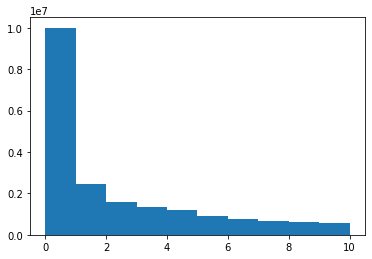

time: 376 ms (started: 2021-07-25 14:57:30 -03:00)


In [39]:
plt.hist(x)

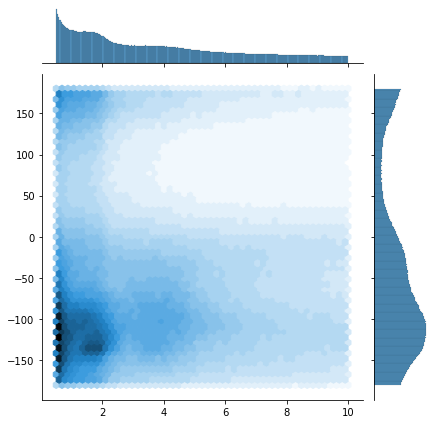

time: 6.68 s (started: 2021-07-25 14:58:48 -03:00)


In [42]:
g = sns.jointplot(x=x[x > 0.5],
                  y=y[x > 0.5], 
                  kind="hex",
                  bins=30)

In [13]:
# fig = px.density_heatmap(x=a.speed_in_kph.values.flatten(), 
#                          y=a.angle_in_degree.values.flatten(),
#                          marginal_x="histogram", 
#                          marginal_y="histogram",
#                          nbinsx=40,
#                          nbinsy=20)
# fig.show()

time: 149 µs (started: 2021-07-25 14:51:49 -03:00)


In [14]:
np.mean(x)

3.8872404

time: 34.6 ms (started: 2021-07-25 14:51:49 -03:00)


In [15]:
np.median(x)

1.6241665

time: 210 ms (started: 2021-07-25 14:51:49 -03:00)


In [47]:
np.percentile(x, 95) - np.percentile(x, 5)

8.256704521179199

time: 269 ms (started: 2021-07-25 15:00:39 -03:00)


In [45]:
import scipy.stats as st
print(st.circmean(y[x > 1], low=-180, high=180))
print(st.circstd(y[x > 1], low=-180, high=180))

-98.59892562281192
77.56285998917983
time: 398 ms (started: 2021-07-25 14:59:31 -03:00)


In [46]:
angle_in_rad = np.arctan2(route_df.delta_x.sum(), route_df.delta_y.sum())
total_distance = route_df.delta.sum() / 1000
projected_distance = (route_df.delta_x.sum() ** 2 + route_df.delta_y.sum() ** 2) ** (1/2) / 1000

print(f"Angle:  {360 * angle_in_rad / (2 * np.pi)} deg")

print(f"Projection:  {360 * np.arctan2(route_df.delta_x.sum(), route_df.delta_y.sum()) / (2 * np.pi)} deg")

Angle:  170.4787550072558 deg
Projection:  170.4787550072558 deg
time: 11.7 ms (started: 2021-07-25 14:59:34 -03:00)


In [18]:
wind_ang = (2 * np.pi) * -104 / 180
print(np.sin(wind_ang))
print(np.cos(wind_ang))

0.46947156278589086
-0.8829475928589269
time: 315 µs (started: 2021-07-25 14:51:49 -03:00)


In [19]:
ang = (2 * np.pi) * 170 / 180
print(np.sin(ang))
print(np.cos(ang))

-0.34202014332566855
0.9396926207859084
time: 410 µs (started: 2021-07-25 14:51:49 -03:00)


In [20]:
print(np.cos(ang) - np.sin(wind_ang))
print(np.sin(ang) - np.cos(wind_ang))

0.47022105800001757
0.5409274495332583
time: 319 µs (started: 2021-07-25 14:51:49 -03:00)


In [21]:
180 * 3 * np.pi / (2 * np.pi)

270.0

time: 2.38 ms (started: 2021-07-25 14:51:49 -03:00)


In [22]:
180-104

76

time: 825 µs (started: 2021-07-25 14:51:49 -03:00)
